# The Worst Fantasy Premier League Team Money Can Buy

Fantasy Premier League is an online competition held by the English Premier League each year in which football fans are given a virtual budget of £100m and tasked with creating a squad of the best 15 players they can from the Premier League. Points are awarded to fans based on how their players perform in real life matches, with points being earned for actions such as scoring goals, making saves, and getting assists; and points being deducted for actions such as conceding goals or receiving yellow or red cards.

Usually, the aim is to build a squad that scores as many points as possible to beat your friends and even win prizes for scoring the highest among the 8 million+ users playing. Usually. This project is going to attempt the opposite. Employing data from the Fantasy Premier League API, we will attempt to quantitatively investigate the worst way to play the game. Spending all of your money for the least return.

## The Rules
The rules of our experiment are quite simple:

* We must spend all £100m of our budget
* Our squad must follow the Fantasy Premier League's rules on squad building (Must have 2 goalkeepers, 5 defenders, 5 midfielders, 3 forwards, and no more than 3 players from the same Premier League team)

If the task becomes trivial and the £100m can be spent in its entirety on players who simply do not play a single minute of football for their club, an extra rule will be added to require a minimum of $x$ minutes played by each player, where $x$ will be decided based on the average minutes played.

## Project Method
The proposed method will be to:
1. Analyse historical data to build the worst teams of the past
2. Analyse what attributes contributed to those teams/players having low scores and high costs associated with them
3. Train a model to predict what players will be in the 'Worst Fantasy Premier League Team Money Can Buy' for the upcoming 2021/22 season

## Gathering Data

In [11]:
#import relevant libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
base_url = 'https://fantasy.premierleague.com/api/' # The base URL from which we will access the FPL API
r = requests.get(base_url+'bootstrap-static/')
json = r.json()
json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

Having researched [this article](https://medium.com/@frenzelts/fantasy-premier-league-api-endpoints-a-detailed-guide-acbd5598eb19) about the Fantasy Premier League API, the keys of the json file can be expressed as the following:

| Key | Description |
| --- | --- |
| events | Basic information about each gameweek such as average score, highest score, top scoring player, etc. |
| game_settings | The game settings and rules |
| phases | Phases of the Fantasy Premier League Season (September, October, etc.) |
| teams | Basic information of current Premier League clubs |
| total_players | Total Fantasy Premier League players |
| elements | Information of all Premier League players including points, status, value, match stats (goals, assists, etc.), etc. |
| element_types | Basic information about player's position |

From this, it looks like the `elements` table will be of most use to us now, alongside the `element_types`, and `teams` to ensure that we are following the squad building rules.

In [13]:
#Create Pandas DataFrames from the relevant tables
elements = pd.DataFrame(json['elements'])
element_types = pd.DataFrame(json['element_types'])
teams = pd.DataFrame(json['teams'])

In [14]:
elements.columns

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam',
       'news', 'news_added', 'now_cost', 'photo', 'points_per_game',
       'second_name', 'selected_by_percent', 'special', 'squad_number',
       'status', 'team', 'team_code', 'total_points', 'transfers_in',
       'transfers_in_event', 'transfers_out', 'transfers_out_event',
       'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'influence_rank', 'influence_rank_type', 'creativity_rank',
       'creativity_rank_type', 'threat_rank'

Having a look at the columns we can see that the `elements` DataFrame we can see that there are many columns which could be useful for predicting a players `total_points` in a season as well as a few identifying columns such as the player `id`, `first_name`, and `second_name`. To know which of these columns we want to keep we will calculate the correlation between them and `total_points`.

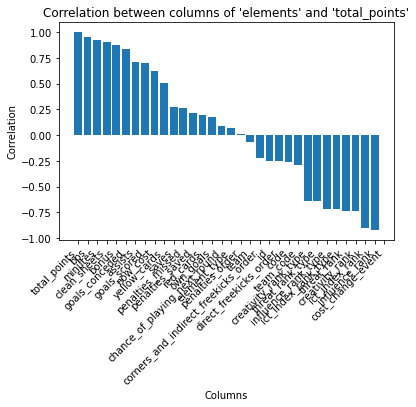

In [15]:
corr_to_pts = pd.Series(elements.corr()['total_points'])
corr_to_pts.sort_values(ascending=False, inplace=True)
plt.bar(corr_to_pts.index, corr_to_pts)
plt.xticks(rotation=45, ha='right')
plt.title("Correlation between columns of 'elements' and 'total_points'")
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.show()

Looking at the plot above, it's clear that there are three distinct sections:
1. Columns with a correlation above +0.5
2. Columns with a correlation between +0.5 and -0.5
3. Columns with a correlation below -0.5

The columns that interest us are those in the first and last section.

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


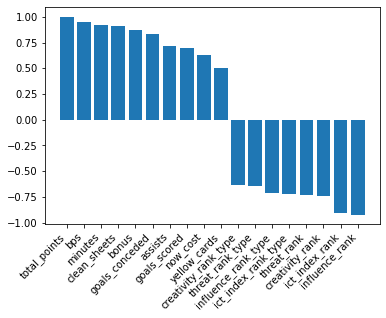

In [16]:
corr_to_pts_extreme = pd.Series()
for i, val in corr_to_pts.items():
    if abs(val) > 0.5:
        corr_to_pts_extreme[i] = val
plt.bar(corr_to_pts_extreme.index, corr_to_pts_extreme)
plt.xticks(rotation=45, ha='right')
plt.show()

With the columns from the middle section removed it's easy to see the columns with the highest correlation to `total_points`. These are `bps`, which is the column for bonus points which are awarded to the three players with the most bonus points each match (bonus points are awarded as per the [scoring section of the Fantasy Premier League Rules](https://fantasy.premierleague.com/help/rules)), `minutes`, `influence_rank`, which ranks players with a higher influence score with a smaller number, `ict_index_rank`, which ranks players with a higher combined influence, creativity, and threat score with a smaller number, and `clean_sheets`.

One interesting column that had a high positive correlation is `goals_conceded`. Considering a player (defender or goalkeeper) scores -1 point for every two goals conceded in a match, as well as losing out on a clean sheet for the first goal conceded in a match, one would expect the number of goals that a player concedes to be negatively correlated with their `total_points` rather than correlated positively. One possible reason for this is that forwards are not negatively effected by their team conceding a goal, and perhaps this pushes teams to play more aggressively and increases their chances of scoring goals which will predominently be scored by forwards. A further look into how the correlations change for each position will be conducted below.

Before that however, it is worth noting that there is roughly a 0.65 correlation between the cost of a player and their `total_points`. This implies that although more expensive players are more likely to score more points, there is value in the market where players with lower costs will outperform their more expensive counterparts (and more importantly for our purposes, there will be expensive players who score few points).

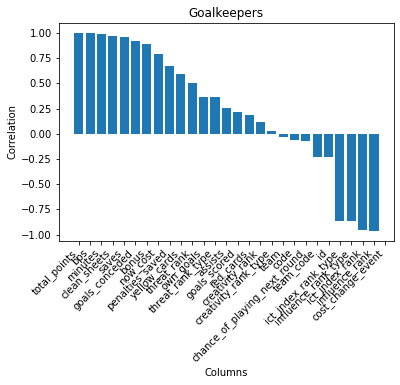

In [19]:
gk_corr_pts = pd.Series(elements[elements['element_type']==1].corr()['total_points'])
gk_corr_pts.sort_values(ascending=False, inplace=True)
plt.bar(gk_corr_pts.index, gk_corr_pts)
plt.xticks(rotation=45, ha='right')
plt.title("Goalkeepers")
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.show()

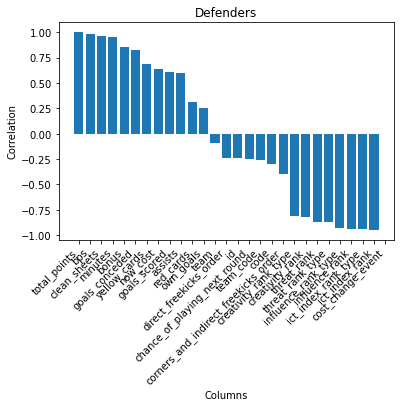

In [20]:
df_corr_pts = pd.Series(elements[elements['element_type']==2].corr()['total_points'])
df_corr_pts.sort_values(ascending=False, inplace=True)
plt.bar(df_corr_pts.index, df_corr_pts)
plt.xticks(rotation=45, ha='right')
plt.title("Defenders")
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.show()

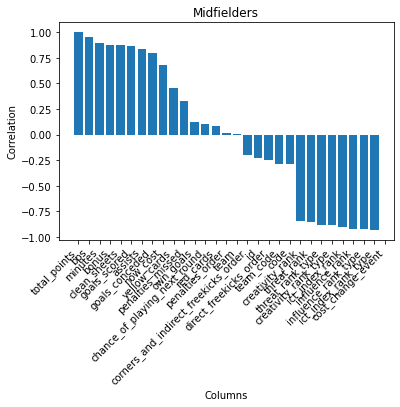

In [21]:
md_corr_pts = pd.Series(elements[elements['element_type']==3].corr()['total_points'])
md_corr_pts.sort_values(ascending=False, inplace=True)
plt.bar(md_corr_pts.index, md_corr_pts)
plt.xticks(rotation=45, ha='right')
plt.title("Midfielders")
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.show()

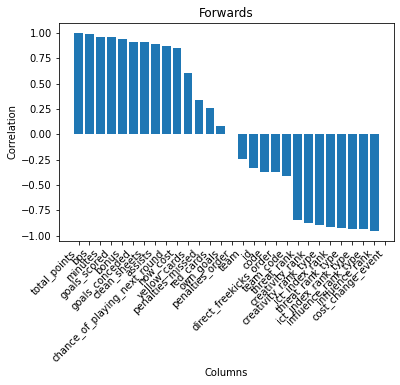

In [28]:
fw_corr_pts = pd.Series(elements[elements['element_type']==4].corr()['total_points'])
fw_corr_pts.sort_values(ascending=False, inplace=True)
plt.bar(fw_corr_pts.index, fw_corr_pts)
plt.xticks(rotation=45, ha='right')
plt.title("Forwards")
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.show()

Although there are definitely differences between the positions when it comes to their correlation to `total_points`, with defenders seemingly having the lowest correlation between price and points, they all show a strong positive correlation with `goals_conceded`, even defenders who stand to lose equally the most by conceding a goal, and gain the least by playing against a team that shoots often.

Having considered that `yellow_cards` is also positively correlated with `total_points` despite it scoring -1 points, it is plausible to assume that these columns simply have a high correlation to another point scoring column (such as `minutes`) and this is why they are positively correlated with total points.

In [31]:
elements.corr()['minutes'].sort_values(ascending=False)

minutes                                 1.000000
bps                                     0.964783
goals_conceded                          0.950921
clean_sheets                            0.927056
total_points                            0.923041
bonus                                   0.703313
yellow_cards                            0.667515
assists                                 0.547234
goals_scored                            0.469090
now_cost                                0.391726
saves                                   0.292652
red_cards                               0.252712
own_goals                               0.233605
penalties_saved                         0.218324
penalties_missed                        0.176831
chance_of_playing_next_round            0.054654
penalties_order                         0.024777
element_type                           -0.017904
team                                   -0.070431
direct_freekicks_order                 -0.184308
corners_and_indirect

Looking at the above, this seems to be the case with `goals_conceded` and `yellow_cards` having a 0.95 and 0.67 correlation with `minutes` respectively.

In [4]:
#DataFrame with only the extremely (>0.5) correlated elements, as well as identifying elements
df = elements[['id', 'element_type', 'first_name', 'second_name', 'web_name', 'now_cost', 'total_points', 'bps', 'minutes', 'clean_sheets', 'bonus', 'goals_conceded', 'assists', 'goals_scored', 'yellow_cards', 'creativity_rank_type', 'threat_rank_type', 'threat_rank_type', 'influence_rank_type', 'ict_index_rank_type', 'threat_rank', 'creativity_rank', 'ict_index_rank', 'influence_rank']]
df.head()

,id,element_type,first_name,second_name,web_name,now_cost,total_points,bps,minutes,clean_sheets,...,yellow_cards,creativity_rank_type,threat_rank_type,threat_rank_type,influence_rank_type,ict_index_rank_type,threat_rank,creativity_rank,ict_index_rank,influence_rank
0,1,1,Bernd,Leno,Leno,50,131,625,3131,11,...,0,50,4,4,12,13,333,455,198,42
1,2,1,Rúnar Alex,Rúnarsson,Rúnarsson,40,1,8,15,0,...,0,19,15,15,31,32,348,356,362,353
2,3,3,Willian,Borges Da Silva,Willian,65,78,306,1398,3,...,0,36,85,85,96,71,146,49,124,224
3,4,4,Pierre-Emerick,Aubameyang,Aubameyang,100,131,358,2330,10,...,2,12,16,16,18,18,32,90,50,125
4,5,2,Cédric,Soares,Cédric,45,28,125,744,2,...,1,52,87,87,110,101,265,209,295,299
